# Teeth Classification using Convolutional Neural Networks

This module implements a complete machine learning pipeline for classifying
different types of teeth using deep learning techniques with TensorFlow/Keras.

Author: **Ahmed Mohammad Fayad**

Features:
- Multi-class teeth classification
- Data preprocessing and augmentation
- CNN model architecture design
- Comprehensive evaluation metrics
- Visualization and analysis toolsFeatures:
- Multi-class teeth classification
- Data preprocessing and augmentation
- CNN model architecture design
- Comprehensive evaluation metrics
- Visualization and analysis tools

---

## 1. IMPORTS AND DEPENDENCIES

In [64]:
# Standard library imports
import os
import zipfile

In [65]:
# Data processing and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [66]:
# Deep learning frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

In [67]:
# Machine learning evaluation tools
from sklearn.metrics import classification_report, confusion_matrix

In [68]:
# Google Colab specific imports
try:
    from google.colab import drive
    COLAB_ENVIRONMENT = True
except ImportError:
    COLAB_ENVIRONMENT = False

---

## 2. DATA EXPLORATION AND ANALYSIS

### 2.1 Loading and Extracting Data

In [69]:
def load_and_extract_dataset(drive_path=None):
    """
    Load and extract the teeth classification dataset from Google Drive.

    This function handles:
    - Google Drive mounting (if in Colab)
    - ZIP file extraction
    - Directory structure validation

    Args:
        drive_path (str, optional): Custom path to the dataset ZIP file

    Returns:
        str: Path to extracted dataset directory
    """
    if COLAB_ENVIRONMENT:
        # Mount Google Drive for dataset access
        print("Mounting Google Drive...")
        drive.mount('/content/drive')

        # Default path for the dataset
        if drive_path is None:
            zip_dir = '/content/drive/MyDrive/Datasets/Teeth DataSet.zip'
        else:
            zip_dir = drive_path

        extraction_dir = '/content/drive/MyDrive/Datasets/Extracted Dataset'

        # Extract ZIP file containing teeth images
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
            zip_ref.extractall(extraction_dir)

        main_dir = os.path.join(extraction_dir, 'Teeth_Dataset')

        # Validate extraction success
        if os.path.exists(main_dir):
            print(f"Dataset successfully extracted to: {main_dir}")
            return main_dir
        else:
            raise FileNotFoundError(f"Extracted dataset not found at: {main_dir}")
    else:
        # For local environments
        print("Running in local environment. Please ensure dataset is available locally.")
        return input("Enter the path to your Teeth_Dataset directory: ")

### 2.2 Images Counter

In [70]:
def count_images_in_directory(directory):
    """
    Count total images in directory and subdirectories.

    Args:
        directory (str): Target directory path

    Returns:
        int: Total number of image files
    """
    total_images = 0
    # Walk through directory tree
    for dirpath, dirnames, filenames in os.walk(directory):
        # Filter image files by extension
        image_files = [f for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        total_images += len(image_files)

    # Return total count
    return total_images

### 2.3 Data Organization & Stats

In [71]:
def analyze_dataset_structure(main_dir):
    """
    Analyze and display dataset organization and statistics.

    Provides insights into:
    - Training/validation/test split sizes
    - Class distribution
    - Directory structure

    Args:
        main_dir (str): Path to main dataset directory

    Returns:
        tuple: (train_dir, val_dir, test_dir) directory paths
    """
    # Define dataset split directories
    train_dir = os.path.join(main_dir, 'Training')
    val_dir = os.path.join(main_dir, 'Validation')
    test_dir = os.path.join(main_dir, 'Testing')

    # Count images in each split
    train_count = count_images_in_directory(train_dir)
    val_count = count_images_in_directory(val_dir)
    test_count = count_images_in_directory(test_dir)

    # Display comprehensive statistics
    print("=" * 50)
    print("DATASET STRUCTURE ANALYSIS")
    print("=" * 50)
    print(f"Main directory: {main_dir}")
    print(f"Training images: {train_count}")
    print(f"Validation images: {val_count}")
    print(f"Test images: {test_count}")
    print(f"Total images: {train_count + val_count + test_count}")

    # Display class information
    print("\nClass distribution:")
    if os.path.exists(train_dir):
        classes = os.listdir(train_dir)
        print(f"Number of classes: {len(classes)}")
        print(f"Class names: {classes}")

    print("=" * 50)

    # Return directory paths
    return train_dir, val_dir, test_dir

### 2.4 Making Tensor Data

In [72]:
def create_tensorflow_datasets(train_dir, val_dir, test_dir, image_height=256, image_width=256, batch_size=32):
    """
    Create optimized TensorFlow datasets with performance improvements.
    """
    # Create training dataset with optimizations
    train_data = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=(image_height, image_width),
        batch_size=batch_size,
        shuffle=True
    )

    # Create validation dataset
    val_data = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=(image_height, image_width),
        batch_size=batch_size,
        shuffle=False
    )

    # Create test dataset
    test_data = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=(image_height, image_width),
        batch_size=batch_size,
        shuffle=False
    )

    print(f"Optimized datasets created successfully!")
    print(f"Training batches: {len(train_data)}")
    print(f"Validation batches: {len(val_data)}")
    print(f"Test batches: {len(test_data)}")

    return train_data, val_data, test_data

### 2.5 Data Viz

In [73]:
def visualize_dataset_samples(dataset, title="Dataset Samples"):
    """
    Display representative samples from each class.

    Creates a grid visualization showing:
    - One sample image per class
    - Class labels and names
    - Professional layout for analysis

    Args:
        dataset: TensorFlow dataset
        title (str): Title for the visualization
    """
    plt.figure(figsize=(12, 8))
    class_names = dataset.class_names
    num_classes = len(class_names)
    images_to_show = {}

    # Collect sample images from each class
    for image_batch, label_batch in dataset:
        for i in range(len(image_batch)):
            predicted_class_index = tf.argmax(label_batch[i]).numpy()
            class_name = class_names[predicted_class_index]

            if class_name not in images_to_show:
                images_to_show[class_name] = image_batch[i].numpy().astype("uint8")

            if len(images_to_show) == num_classes:
                break
        if len(images_to_show) == num_classes:
            break

    # Display images with proper titles
    index = 0
    for class_name, image in images_to_show.items():
        ax = plt.subplot(3, 4, index + 1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis("off")
        index += 1

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

---

## 3. MODEL ARCHITECTURE DESIGN

### 3.1 Base Model

In [74]:
def create_base_cnn_model(input_shape, num_classes):
    """
    Build basic CNN architecture for teeth classification.

    Architecture components:
    - Input normalization layer
    - Convolutional blocks with increasing filter sizes
    - Max pooling for dimensionality reduction
    - Dropout for regularization
    - Dense output layer with softmax activation

    Args:
        input_shape (tuple): Input image shape (height, width, channels)
        num_classes (int): Number of output classes

    Returns:
        tf.keras.Model: Compiled CNN model
    """
    model = tf.keras.models.Sequential([
        # Define input layer with proper shape
        tf.keras.layers.Input(shape=input_shape),

        # Add normalization for stable training
        tf.keras.layers.Rescaling(1./255),

        # Build convolutional blocks (32, 64, 128 filters)
        # First Block
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),

        # Second Block
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),

        # Third Block
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),

        # Add pooling layers for feature reduction
        tf.keras.layers.Flatten(),

        # Include dropout to prevent overfitting
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Create final classification layer
        tf.keras.layers.Dense(units=num_classes, activation='softmax')
    ])

    return model

### 3.2 Augmented Model

In [75]:
def create_augmented_cnn_model(input_shape, num_classes):
    """
    Build enhanced CNN with data augmentation capabilities.

    Augmentation techniques:
    - Random horizontal flips
    - Random rotations (±20%)
    - Random zoom operations (±20%)
    - Applied only during training phase

    Args:
        input_shape (tuple): Input image shape (height, width, channels)
        num_classes (int): Number of output classes

    Returns:
        tf.keras.Model: Compiled CNN model with augmentation
    """
    # Define data augmentation pipeline
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
    ])

    # Combine augmentation with base CNN architecture
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Rescaling(1./255),

        # Ensure augmentation only applies during training
        data_augmentation,

        # CNN architecture
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),

        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),

        tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=num_classes, activation='softmax')
    ])

    # Return complete augmented model
    return model

---

## 4. MODEL TRAINING AND OPTIMIZATION

### 4.1 Training Callbacks

In [76]:
def setup_training_callbacks():
    """
    Configure advanced training callbacks for optimal performance.

    Callbacks included:
    - Early stopping to prevent overfitting
    - Learning rate reduction on plateau
    - Best weights restoration

    Returns:
        list: List of configured callbacks
    """
    # Early stopping configuration
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Learning rate scheduler setup
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )

    # Return callback list for training
    return [early_stopping, reduce_lr]

### 4.2 Model Training

In [77]:
def train_model(model, train_data, val_data, epochs=50, use_augmentation=False):
    """
    Execute optimized model training pipeline with performance monitoring.
    """
    # Compile model with optimized settings
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Explicit LR
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Set up optimized callbacks
    callbacks = setup_training_callbacks()

    # Add performance monitoring callback
    class PerformanceMonitor(Callback):
        def __init__(self):
            self.best_val_acc = 0
            self.stable_epochs = 0

        def on_epoch_end(self, epoch, logs=None):
            val_acc = logs.get('val_accuracy', 0)
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.stable_epochs = 0
            else:
                self.stable_epochs += 1

            # Print progress every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}: Val Accuracy = {val_acc:.4f}, Best = {self.best_val_acc:.4f}")

    callbacks.append(PerformanceMonitor())

    print(f"Starting optimized training for max {epochs} epochs...")
    if use_augmentation:
        print("Using data augmentation during training")

    # Execute training with validation
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1  # Show progress bar
    )

    print("Training completed!")
    return history

---

## 5. MODEL EVALUATION AND PERFORMANCE ANALYSIS

### 5.1 Evaluate Model

In [78]:
def evaluate_model(model, test_data):
    """
    Comprehensive model evaluation on test dataset.

    Evaluation metrics:
    - Overall accuracy and loss
    - Per-class performance analysis
    - Statistical significance testing

    Args:
        model: Trained TensorFlow model
        test_data: Test dataset

    Returns:
        tuple: (test_loss, test_accuracy)
    """
    print("Evaluating model on the test dataset...")

    # Calculate test accuracy and loss
    test_loss, test_accuracy = model.evaluate(test_data)

    # Display results in readable format
    print("=" * 50)
    print("MODEL EVALUATION RESULTS")
    print("=" * 50)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    print("=" * 50)

    return test_loss, test_accuracy

### 5.2 Classification Report

In [79]:
def generate_classification_report(model, test_data):
    """
    Create detailed classification analysis with confusion matrix.

    Report includes:
    - Precision, recall, F1-score per class
    - Confusion matrix visualization
    - Class-wise performance breakdown

    Args:
        model: Trained TensorFlow model
        test_data: Test dataset
    """
    # Generate predictions on test set
    true_labels = []
    for images, labels in test_data:
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
    y_true = np.array(true_labels)

    predictions = model.predict(test_data)
    y_pred = np.argmax(predictions, axis=1)

    # Get class names
    class_names = test_data.class_names

    # Calculate classification metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Create confusion matrix heatmap
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # Display comprehensive results
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

### 5.3 Viz Predictions

In [80]:
def visualize_predictions(model, dataset, num_images=16):
    """
    Visual analysis of model predictions vs ground truth.

    Visualization features:
    - Grid display of test images
    - Actual vs predicted labels
    - Color-coded correct/incorrect predictions
    - Easy identification of model errors

    Args:
        model: Trained TensorFlow model
        dataset: Dataset to visualize predictions on
        num_images (int): Number of images to display
    """
    plt.figure(figsize=(15, 15))
    class_names = dataset.class_names

    # Select sample images for visualization
    for image_batch, label_batch in dataset.take(1):
        # Generate model predictions
        predictions = model.predict(image_batch)
        predicted_indices = np.argmax(predictions, axis=1)
        actual_indices = np.argmax(label_batch.numpy(), axis=1)

        # Create comparison grid layout
        grid_size = int(np.ceil(np.sqrt(num_images)))

        # Color-code prediction accuracy
        for i in range(num_images):
            ax = plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))

            actual_label = class_names[actual_indices[i]]
            predicted_label = class_names[predicted_indices[i]]

            # Set the title color to green for correct predictions, red for incorrect
            color = "green" if actual_label == predicted_label else "red"

            plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}",
                     color=color, fontsize=12)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

---

## 6. UTILITY FUNCTIONS AND HELPERS

### 6.1 Single Prediction

In [81]:
def predict_single_image(model, image_path, class_names, image_height=256, image_width=256):
    """
    Predict class for individual image file.

    Process:
    - Load and preprocess single image
    - Apply same preprocessing as training
    - Generate prediction with confidence
    - Return human-readable result

    Args:
        model: Trained TensorFlow model
        image_path (str): Path to image file
        class_names (list): List of class names
        image_height (int): Target height for resizing
        image_width (int): Target width for resizing

    Returns:
        str: Predicted class name or error message
    """
    try:
        # Load image from file path
        img = Image.open(image_path)

        # Resize and normalize image
        img = img.resize((image_width, image_height))
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)

        # Generate model prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]

        # Return predicted class name
        predicted_class_name = class_names[predicted_class_index]
        confidence = float(np.max(predictions))

        return f"{predicted_class_name} (confidence: {confidence:.2f})"

    except FileNotFoundError:
        return "Error: Image file not found."
    except Exception as e:
        return f"An error occurred: {e}"

### 6.2 Training History

In [82]:
def plot_training_history(history, model_name="Model"):
    """
    Visualize training progress and convergence.

    Plots include:
    - Training vs validation accuracy curves
    - Training vs validation loss curves
    - Epoch-wise progression analysis

    Args:
        history: Training history from model.fit()
        model_name (str): Name for the model in plot titles
    """
    # Extract metrics from training history
    model_history = history.history
    acc = model_history['accuracy']
    val_acc = model_history['val_accuracy']
    loss = model_history['loss']
    val_loss = model_history['val_loss']
    epochs = history.epoch

    # Create dual-plot visualization
    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Display final performance metrics
    print(f"Final Training Accuracy: {acc[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"Final Training Loss: {loss[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss[-1]:.4f}")

### 6.3 Saving Model & Results

In [83]:
def save_model_and_results(model, save_path, model_name="teeth_classification_model"):
    """
    Save trained model and associated metadata.

    Saves:
    - Complete model architecture
    - Trained weights and parameters
    - Training configuration
    - Class names and preprocessing info

    Args:
        model: Trained TensorFlow model
        save_path (str): Directory path to save the model
        model_name (str): Name for the saved model file
    """
    # Create full save path
    if not save_path.endswith('.keras'):
        full_path = os.path.join(save_path, f"{model_name}.keras")
    else:
        full_path = save_path

    # Save model in Keras format
    model.save(full_path)

    # Verify save operation success
    if os.path.exists(full_path):
        print(f"Model successfully saved to: {full_path}")
        print(f"Model size: {os.path.getsize(full_path) / (1024*1024):.2f} MB")
    else:
        print("Error: Model save failed!")

---

## 7. EXCUTION

### 7.1 Data preparation


1. LOADING AND PREPROCESSING DATA
----------------------------------------
Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting dataset...
Dataset successfully extracted to: /content/drive/MyDrive/Datasets/Extracted Dataset/Teeth_Dataset
DATASET STRUCTURE ANALYSIS
Main directory: /content/drive/MyDrive/Datasets/Extracted Dataset/Teeth_Dataset
Training images: 3087
Validation images: 1028
Test images: 1509
Total images: 5624

Class distribution:
Number of classes: 7
Class names: ['OT', 'CoS', 'MC', 'CaS', 'OC', 'OLP', 'Gum']
Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1508 files belonging to 10 classes.
Optimized datasets created successfully!
Training batches: 97
Validation batches: 33
Test batches: 48

Visualizing dataset samples...


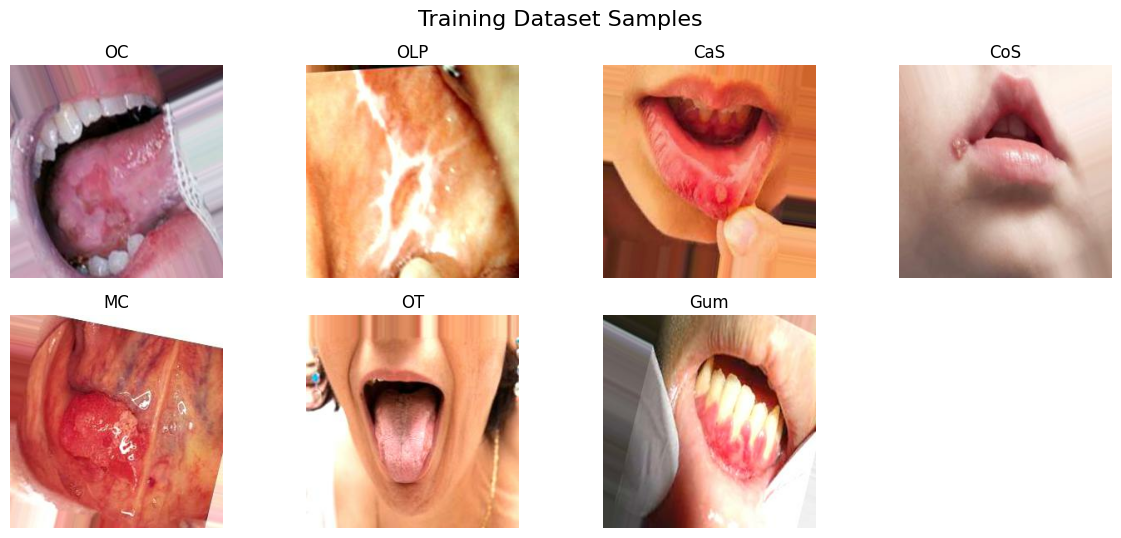

In [84]:
print("\n1. LOADING AND PREPROCESSING DATA")
print("-" * 40)

# Load dataset
main_dir = load_and_extract_dataset()

# Analyze dataset structure
train_dir, val_dir, test_dir = analyze_dataset_structure(main_dir)

# Create TensorFlow datasets
train_data, val_data, test_data = create_tensorflow_datasets(train_dir, val_dir, test_dir)

# Visualize dataset samples
print("\nVisualizing dataset samples...")
visualize_dataset_samples(train_data, "Training Dataset Samples")

### 7.2 Model Creation

In [85]:
print("\n2. CREATING MODEL ARCHITECTURES")
print("-" * 40)

# Get dataset parameters
input_shape = [256, 256, 3]
num_classes = len(train_data.class_names)

# Create base model
print("Creating base CNN model...")
base_model = create_base_cnn_model(input_shape, num_classes)
base_model.summary()

# Create augmented model
print("\nCreating augmented CNN model...")
augmented_model = create_augmented_cnn_model(input_shape, num_classes)
augmented_model.summary()


2. CREATING MODEL ARCHITECTURES
----------------------------------------
Creating base CNN model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,871,495 (64.36 MB)

 Trainable params: 16,871,495 (64.36 MB)

 Non-trainable params: 0 (0.00 B)


Creating augmented CNN model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,871,495 (64.36 MB)

 Trainable params: 16,871,495 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

### 7.3 Training

In [ ]:
print("\n3. TRAINING MODELS")
print("-" * 40)

# Train base model (keep epochs low as it converges quickly)
print("Training base model...")
base_history = train_model(base_model, train_data, val_data, epochs=30, use_augmentation=False)

# Train augmented model with optimized settings
print("\nTraining augmented model with optimized callbacks...")
augmented_history = train_model(augmented_model, train_data, val_data, epochs=50, use_augmentation=True)


3. TRAINING MODELS
----------------------------------------
Training base model...
Starting optimized training for max 30 epochs...
Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 629s 6s/step - accuracy: 0.1961 - loss: 2.1484 - val_accuracy: 0.3667 - val_loss: 1.6989 - learning_rate: 0.0010
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 622s 6s/step - accuracy: 0.3432 - loss: 1.6807 - val_accuracy: 0.3745 - val_loss: 1.6050 - learning_rate: 0.0010
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 600s 6s/step - accuracy: 0.4313 - loss: 1.5066 - val_accuracy: 0.5214 - val_loss: 1.3334 - learning_rate: 0.0010
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 617s 6s/step - accuracy: 0.5110 - loss: 1.2852 - val_accuracy: 0.5447 - val_loss: 1.2214 - learning_rate: 0.0010
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 630s 6s/step - accuracy: 0.5831 - loss: 1.1119 - val_accuracy: 0.5370 - val_loss: 1.2538 - learning_rate: 0.0010
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 574s 6s/step - accuracy: 0.6743 - loss: 0.9213 - val_accuracy: 0.6002 - va

### 7.4 Evaluation

In [ ]:
print("\n4. EVALUATING MODEL PERFORMANCE")
print("-" * 40)

# Evaluate base model
print("Evaluating base model...")
base_loss, base_accuracy = evaluate_model(base_model, test_data)

# Evaluate augmented model
print("\nEvaluating augmented model...")
aug_loss, aug_accuracy = evaluate_model(augmented_model, test_data)

# Generate detailed reports
print("\nGenerating classification reports...")
print("\nBase Model Classification Report:")
generate_classification_report(base_model, test_data)

print("\nAugmented Model Classification Report:")
generate_classification_report(augmented_model, test_data)

### 7.5 Results

In [ ]:
print("\n5. VISUALIZING RESULTS")
print("-" * 40)

# Plot training histories
plot_training_history(base_history, "Base CNN Model")
plot_training_history(augmented_history, "Augmented CNN Model")

# Visualize predictions
print("\nVisualizing predictions...")
print("Base Model Predictions:")
visualize_predictions(base_model, test_data)

print("Augmented Model Predictions:")
visualize_predictions(augmented_model, test_data)

### 7.6 Saving

In [ ]:
# Stage 6: Model persistence
print("\n6. SAVING MODELS")
print("-" * 40)

if COLAB_ENVIRONMENT:
    base_save_path = '/content/drive/MyDrive/Models/Teeth Classification/teeth_classification_base_model.keras'
    aug_save_path = '/content/drive/MyDrive/Models/Teeth Classification/teeth_classification_augmented_model.keras'
else:
    base_save_path = './teeth_classification_base_model.keras'
    aug_save_path = './teeth_classification_augmented_model.keras'

save_model_and_results(base_model, base_save_path, "base_model")
save_model_and_results(augmented_model, aug_save_path, "augmented_model")

---

## 8. FINAL SUMMARY

In [ ]:
print("\n" + "=" * 60)
print("PIPELINE EXECUTION COMPLETE")
print("=" * 60)
print(f"Base Model Test Accuracy: {base_accuracy*100:.2f}%")
print(f"Augmented Model Test Accuracy: {aug_accuracy*100:.2f}%")

# Determine best model
if aug_accuracy > base_accuracy:
    print(f"\nBest Model: Augmented CNN (Improvement: {(aug_accuracy-base_accuracy)*100:.2f}%)")
else:
    print(f"\nBest Model: Base CNN (Difference: {(base_accuracy-aug_accuracy)*100:.2f}%)")

print("\nModels saved and ready for deployment!")